In [1]:
%pylab inline                   
import os
import glob
import aplpy
import string
import sys
import dtdutils
reload(dtdutils)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors
from astropy import units as u
from astropy import wcs 
from astropy.io import fits
from astropy.io import ascii 
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy import coordinates as coordf
from astropy.time import Time
from 

DTDpath = os.getenv('DTD')+'/'
plotPathName = DTDpath + 'Writeup/Sarba17_DTDRRLyrae_AASTex/'

plt.rcdefaults()
plt.rcParams.update({'figure.autolayout':'True'})
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.fontset':'stixsans'})
plt.rcParams.update({'axes.linewidth': 0.5})
plt.rcParams.update({'xtick.major.size': 2})
plt.rcParams.update({'xtick.major.width': 0.25 })
plt.rcParams.update({'xtick.minor.size': 1})
plt.rcParams.update({'xtick.minor.width': .25 })
plt.rcParams.update({'ytick.major.size': 2})
plt.rcParams.update({'ytick.major.width': .25 })
plt.rcParams.update({'ytick.minor.size': 1})
plt.rcParams.update({'ytick.minor.width': .25 })

Populating the interactive namespace from numpy and matplotlib


In [75]:
if True:
    fileName = DTDpath + 'InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt'
    firstLine = 7
    lastLine = 24913
    objClassName = 'RRLyrae'
    refName = 'OGLE'

obj_subtype = 'All'
objListRA, objListDec = dtdutils.object_ra_decs(fileName, objClassName, obj_subtype=obj_subtype)

#Read SFH map

sfhFileName = DTDpath + 'MC_SFH_Maps/lmc_sfh.dat'
outPathName = DTDpath + 'Output_SFH_Files/'
plotPathName = DTDpath + 'Writeup/Sarba17_DTDRRLyrae_AASTex/'
print 'Reading SFH from file '+sfhFileName
nCells = 0
nAgeBins = 16
cellNames = []
cellCentersRA = []
cellCentersDec = []
sfhMap = []
with open(sfhFileName, 'r') as f:
    for i in range(17): f.readline()
    while True:
        line = f.readline() #Hyphens
        if not line : 
            print 'End of file reached after cell ', nCells
            break #Check EOF
        
        words = f.readline().split()
        cellNames.append(words[1])  #Cell name    
        #print 'Reading cell ' + cellNames[-1]
        words = f.readline().split() #Cell center
        cellCentersRA.append(float(words[1][0:2]) + float(words[2][0:2])/60.0)
        cellCentersDec.append(float(words[3][0:3]) - float(words[4][0:2])/60.0)
        line = f.readline() #Hyphens
        sfhCell = np.zeros([3,nAgeBins])
        for bin in range(nAgeBins) :
            floats = [float(x) for x in f.readline().split()]
            floatArr = np.asarray(floats)
            sfhCell[0,nAgeBins-1-bin] = floatArr[[1,4,7,10]].sum() #Best Fit
            sfhCell[1,nAgeBins-1-bin] = floatArr[[2,5,8,11]].sum() #Lower limit
            sfhCell[2,nAgeBins-1-bin] = floatArr[[3,6,9,12]].sum() #Upper limit
            f.readline() #Blank line

        sfhMap.append(sfhCell)
        nCells += 1

sfhMapArr = np.asarray(sfhMap)
sfhMapArr = sfhMapArr/1e6 #Appears to be SFH for 'x' number of cells, 3 columns (median, upper, lower)limit and in different agebins        
cellCentersRA = np.asarray(cellCentersRA)
cellCentersDec = np.asarray(cellCentersDec)

#Modified cell centers: read from file
cellCentersFileName = DTDpath + 'MC_SFH_Maps/LMC_SFH_Cell_Centers_Corrected.txt'
undivCells = [item for item in range(nCells) if len(cellNames[item]) == 2]
divCells = [item for item in range(nCells) if len(cellNames[item]) == 5]
nColumns = 24
nRows = 19
with open(cellCentersFileName, 'r') as f:
    for cell in range(nCells) :
        words = f.readline().split()
        cellIndex = cellNames.index(words[0])
        cellCentersRA[cellIndex] = float(words[1])
        cellCentersDec[cellIndex] = float(words[2])
        ## if len(words[0]) == 2 :
        ##     verticesRA = cellCentersRA[cellIndex] + 0.5*raInc*np.array([-1,-1,1,1]) 
        ##     verticesDec = cellCentersDec[cellIndex] + 0.5*decInc*np.array([-1,1,1,-1]) 
            #fig.show_rectangles(cellCentersRA[cellIndex],cellCentersDec[cellIndex],raInc,decInc,color='blue')
            # else :
            # fig.show_rectangles(cellCentersRA[cellIndex],cellCentersDec[cellIndex],0.5*raInc,0.5*decInc,color='blue')
        # print cellNames[cellIndex]


#~~~~~~~~~~~ Not sure what this part of the code is doing~~~~~~~~~~~~~~~~~~~#
raInc = cellCentersRA[3]-cellCentersRA[0] #BA-AA
decInc = cellCentersDec[1]-cellCentersDec[0] #AB-AA
raOrigin = 5.5-13.0*raInc
decOrigin = -72-0.75*decInc
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
#Write file with number of objects in each cell that falls within the survey area
if refName == 'OGLE' : 
    surveyCells = [line.strip() for line in open(DTDpath + 'MC_SFH_Maps/LMC_SFH_Cells_OGLE.txt')]
elif refName == 'Reid&Parker' :
    surveyCells = [line.strip() for line in open(DTDpath + 'MC_SFH_Maps/LMC_SFH_Cells_Reid&Parker.txt')]
#    surveyCells = cellsinSFHSurvey(cellNames, cellCentersRA, cellCentersDec)
else : 
    surveyCells = cellNames
    
nSurveyCells = len(surveyCells)
objRAArr = 15.0*np.asarray(objListRA)
objDecArr = np.asarray(objListDec)
cellInSurvey = np.zeros(nCells,dtype='bool')
nObjAcc = 0
objMap = np.zeros(nCells)
for cell in range(nCells) :
    #Determine if cell is within survey area
    if cellNames[cell] in surveyCells :
        cellInSurvey[cell] = True
        if len(cellNames[cell]) == 2 :
            cellHalfSizeRA = raInc/2.0
            cellHalfSizeDec = decInc/2.0
        else :
            cellHalfSizeRA = raInc/4.0
            cellHalfSizeDec = decInc/4.0
            
        objInCell = np.logical_and(abs(objRAArr - cellCentersRA[cell]) <= cellHalfSizeRA, 
                                   abs(objDecArr - cellCentersDec[cell]) <= cellHalfSizeDec)
        
        nObjInCell = objInCell.sum()
        nObjAcc += nObjInCell
        objMap[cell] = nObjInCell
            
print 'HZ cells in survey area: ', cellInSurvey.sum()
print 'Total objects: ', nObjAcc, objMap.sum()

print cellCentersRA[cellInSurvey].shape
print cellCentersDec[cellInSurvey].shape


line_list = [np.array([[cellCentersRA[0], cellCentersRA[-1]], [cellCentersDec[0], cellCentersDec[0]]])]


#Bin SFH map and write final file
logAgeArr = np.asarray([6.8, 7.1, 7.4, 7.7, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2])
ageArr = 10.0**logAgeArr
logAgeLimsArr = np.asarray([6.65,6.95,7.25,7.55,7.85,8.1,8.3,8.5,8.7,8.9,9.1,9.3,9.5,9.7,9.9,10.1,10.3])
ageLimsArr = 10.0**logAgeLimsArr
ageIntervalsArr = ageLimsArr[1:]-ageLimsArr[:-1]
#ageIntervalsArr = np.asarray([4101224.2, 9404646.0, 18764724., 37440568., 54185272., 75594208.,
#                              1.1980914e+08, 1.8988461e+08, 3.0094621e+08, 4.7696742e+08, 7.5594214e+08, 
#                              1.1980915e+09, 1.8988457e+09, 3.0094623e+09, 4.7696753e+09, 5.9120108e+09])

binningSchemeNames = ['Coarse','Massive','Medium','MediumB','MediumC','Subfine','Fine','CrazyCeph','RRLyraeLB','Unbinned']
nSchemes = len(binningSchemeNames)
#binsList = [[0, 1, 2], [3, 4, 5, 6, 7, 8], [9, 10], [11, 12], [13], [14, 15]] 
binningSchemes = [[[0,1,2,3],[4,5,6,7,8],[9,10,11,12,13,14,15]]
                  ,[[0],[1],[2],[3,4,5,6,7,8,9,10,11,12,13,14,15]]
                  ,[[0,1,2],[3,4,5,6,7,8],[9,10],[11],[12,13],[14,15]]
                  ,[[0,1,2],[3,4,5,6,7,8],[9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5,6],[7,8,9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5],[6,7,8],[9,10],[11,12],[13],[14,15]]
                  ,[[0,1,2],[3,4,5],[6,7,8],[9,10],[11],[12],[13],[14,15]]
                  ,[[0],[1],[2,3],[4],[5,6,7],[8,9],[10,11,12], [13,14,15]]
                  ,[[0,1,2,3,4,5,6,7,8,9],[10],[11],[12],[13,14],[15]]
                  ,range(16)]


corrList = []
corrListNorm = []
sfhMapBinnedList = []
sfhMapTotal = np.reshape(np.dot(sfhMapArr[:,0,:],ageIntervalsArr),nCells)

print '\n\nCreating SFH files ending in .dat\n'
for scheme in range(nSchemes) :
    nBinsScheme = len(binningSchemes[scheme])
    sfhMapBinned = np.zeros((nBinsScheme,3,nCells))
    for bin in range(nBinsScheme) :
        sfhMapBinned[bin,0,:] =  np.reshape(np.dot(sfhMapArr[:,0,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        sfhMapBinned[bin,1,:] =  np.reshape(np.dot(sfhMapArr[:,1,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        sfhMapBinned[bin,2,:] =  np.reshape(np.dot(sfhMapArr[:,2,[(binningSchemes[scheme])[bin]]],ageIntervalsArr[(binningSchemes[scheme])[bin]]),nCells)
        #sfhMapBinned[bin,2,:] =  np.reshape(np.dot(sfhMapArr[:,2,[binsList[bin]]],ageIntervalsArr[[binsList[bin]]]),nCells)

    sfhMapBinnedList.append(sfhMapBinned)

#Plot maps
createMaps = True
if createMaps :                    
    #Create map grid
    gridKey = np.zeros([2*nColumns,2*nRows],dtype=int)
    surveyAreaKey = np.zeros([2*nColumns,2*nRows],dtype=int)
    raKey = np.zeros([2*nColumns, 2*nRows])
    decKey = np.zeros([2*nColumns, 2*nRows])
    gridKey[:,:] = -1
    surveyAreaKey[:,:] = -1
    for cell in range(nCells) :
        colLetter = cellNames[cell][0]
        rowLetter = cellNames[cell][1]
        if len(cellNames[cell]) == 5 :
            colNum = int(cellNames[cell][3])
            rowNum = int(cellNames[cell][4])
            gridKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cell
            raKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cellCentersRA[cell]
            decKey[2*(string.uppercase.find(colLetter))+colNum,2*(string.uppercase.find(rowLetter))+rowNum] = cellCentersDec[cell]
            if cellInSurvey[cell]:
                surveyAreaKey[2*(string.uppercase.find(colLetter))+colNum,\
                              2*(string.uppercase.find(rowLetter))+rowNum] = 0
            #print cellNames[cell], 2*(string.uppercase.find(colLetter))+colNum, 2*(string.uppercase.find(rowLetter))+rowNum
        else :
            gridKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cell
            gridKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cell
            gridKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cell
            gridKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cell
                                                                                                                             
            raKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cellCentersRA[cell]
            raKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cellCentersRA[cell]
                                                                                                                            
            decKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = cellCentersDec[cell]
            decKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = cellCentersDec[cell]
            
            if cellInSurvey[cell]:
                surveyAreaKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))] = 0
                surveyAreaKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))] = 0
                surveyAreaKey[2*(string.uppercase.find(colLetter)),2*(string.uppercase.find(rowLetter))+1] = 0
                surveyAreaKey[2*(string.uppercase.find(colLetter))+1,2*(string.uppercase.find(rowLetter))+1] = 0
            #print cellNames[cell], 2*(string.uppercase.find(colLetter)), 2*(string.uppercase.find(rowLetter))   


    ## #Map the sfh
    sfhMapImages = np.zeros([nAgeBins,2*nColumns,2*nRows])
    sfhMapMassiveImages = np.zeros([4,2*nColumns,2*nRows])
    sfhMapRRLyraeLBImages = np.zeros([6,2*nColumns, 2*nRows])
    for row in range(2*nRows) :
        for column in range(2*nColumns) :
            if gridKey[column,row] >= 0 :
                sfhMapImages[:,column,row] = (sfhMap[gridKey[column,row]])[0]
                sfhMapMassiveImages[:,column,row] = (sfhMapBinnedList[1])[:,0,gridKey[column,row]]
                sfhMapRRLyraeLBImages[:,column,row] = (sfhMapBinnedList[-2])[:,0,gridKey[column,row]]

RRLyrae in the LMC.
Reading object catalog from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/InputFiles/OGLE_LMC_RRLyrae_noOutliers.txt
Reading SFH from file /Users/sumits2k/Desktop/Research/SNResearch2/RadioSNRs/DTD/MC_SFH_Maps/lmc_sfh.dat
End of file reached after cell  1376
HZ cells in survey area:  808
Total objects:  23459 23459.0
(808,)
(808,)


Creating SFH files ending in .dat



Unbinned Map with objects...


/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10


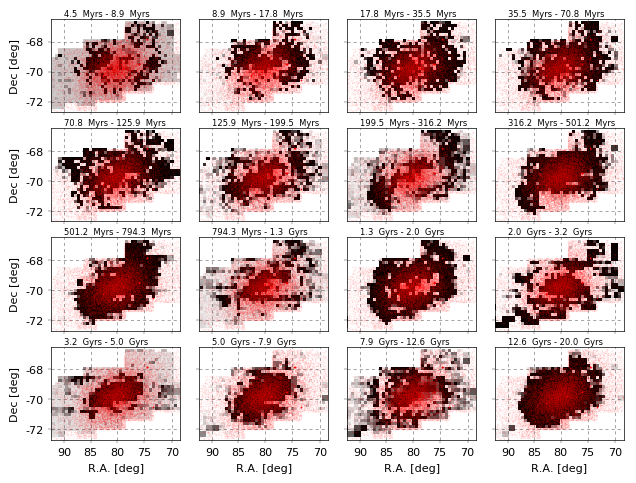

In [131]:
heatmap, xedges, yedges = np.histogram2d((15.0*np.asarray(objListRA)-cellCentersRA[0])/(0.5*raInc),(np.asarray(objListDec)-cellCentersDec[0])/(0.5*decInc), bins=90) 
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
from scipy import interpolate
f_ra = interpolate.interp1d(raKey[:,1], np.arange(0,2*nColumns,1))
ticks_ra = [90, 85, 80, 75, 70]
ticks_ra_pix = f_ra(ticks_ra)
f_dec = interpolate.interp1d(decKey[28], np.arange(0,2*nRows,1))
ticks_dec = [-72, -70, -68, -66]
ticks_dec_pix = f_dec(ticks_dec)

colorscheme = ['#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
#colorscheme = 

 #Plot unbinned
print 'Unbinned Map with objects...'
if True:
    plotFileName = plotPathName+'LMC_'+objClassName+'_'+obj_subtype+'_'+refName+'_Unbinned_Maps.pdf'
    plt.figure(figsize=(15,15))
    f, axArr = plt.subplots(4, 4, sharex=True, sharey=True, squeeze = False) 
    plt.subplots_adjust(hspace=-1, wspace=-1)
    for ageBin in range(nAgeBins):
        row = int(np.floor(ageBin/4))
        column = ageBin-4*row
#        axArr[row,column].set_xlim([2.*nColumns,0])
#        axArr[row,column].set_ylim([0,2.*nRows])
        axArr[row,column].set_xlim(35,10)
        axArr[row,column].set_ylim(0,28)
        axArr[row,column].axis('on')
        axArr[row,column].plot((15.0*np.asarray(objListRA)-cellCentersRA[0])/(0.5*raInc),\
                       (np.asarray(objListDec)-cellCentersDec[0])/(0.5*decInc),\
                        'r+',ms=0.2, alpha=0.12)
        whneg = np.where(surveyAreaKey<0)
        masked_sfhMapImages = np.ma.asarray(sfhMapImages[ageBin])
        masked_sfhMapImages[whneg[0], whneg[1]] = ma.masked
        m = 10**np.mean(np.log10(masked_sfhMapImages))
        s = 10**np.std(np.log10(masked_sfhMapImages))
        axArr[row,column].imshow(masked_sfhMapImages.T, aspect='equal', origin='lower', \
                                interpolation='nearest',cmap = 'Greys', vmin=m-(10.0*s), vmax=m+(10.0*s), alpha=1)
        fact1, unit1 = (1.0e6, ' Myrs') if logAgeLimsArr[ageBin]<9. else (1.0e9, ' Gyrs')
        age1 = np.around(10**logAgeLimsArr[ageBin]/fact1, decimals=1)
        fact2, unit2 = (1.0e6, ' Myrs') if logAgeLimsArr[ageBin+1]<9. else (1.0e9, ' Gyrs')
        age2 = np.around(10**logAgeLimsArr[ageBin+1]/fact2, decimals=1)

        axArr[row,column].text(0.1, 1.03, str(age1)+' '+unit1+' - '+str(age2)+' '+unit2, fontsize=6, transform=axArr[row,column].transAxes)
        #axArr[row,column].set_title(str(age1)+' '+unit1+' - '+str(age2)+' '+unit2, fontsize=6)
#        axArr[row, column].contourf(heatmap.T, extent=extent, levels=[10,50,100,150,200,250], interpolation='cubic', \
#                                    linewidths=1.0, alpha=0.4, colors=colorscheme, origin='lower')
#        axArr[row, column].contour(heatmap.T, extent=extent, levels=[10,50,100], linewidths=0.7, \
#                                    colors='r', origin='lower')
        axArr[row, column].set_xticks(ticks_ra_pix)
        axArr[row, column].set_xticklabels(ticks_ra)
        axArr[row, column].set_yticks(ticks_dec_pix)
        axArr[row, column].set_yticklabels(ticks_dec)
        axArr[row, column].grid(linestyle='dotted', lw=0.5, alpha=0.5, color='k')
        if row==3.:
            axArr[row, column].set_xlabel('R.A. [deg]')
        if column==0.:
            axArr[row, column].set_ylabel('Dec [deg]')
 
    #plt.savefig(plotPathName + 'LMC_RRLyrae_Unbinned_Maps.png', dpi=250)
    plt.show()

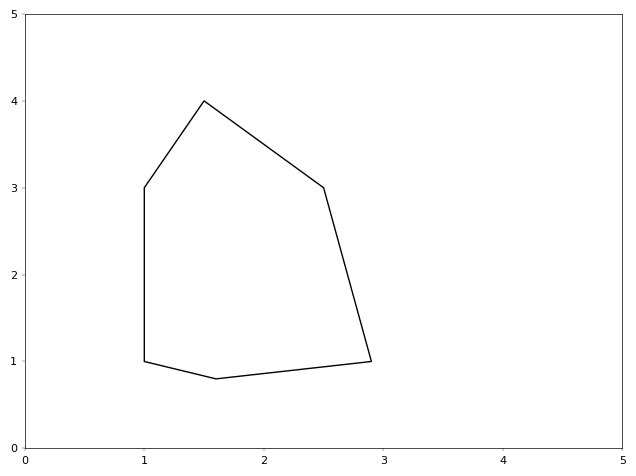

In [4]:
from matplotlib.patches import Polygon
plt.figure()
ax = plt.gca()
poly = Polygon([[1,1], [1,2], [1,3], [1.5,4], [2.5,3], [2.7,2], [2.9,1], [1.6,0.8]], fill=False)
ax.add_patch(poly)
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

In [42]:
a = np.arange(16).reshape(4,4)
print a
print a[[0,0],[0,1]]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[0 1]
